<h1>Q-Learning on Grid World (Mouse Grid) </h1>

# Ziad Al-Ziadi


### 1. Task 1

In this task a tabular reinforcement learning (RL) environment that follows a Markow Decision Process (MDP) will be developed. Details of elements of this environment (states, action and rewards) are provided below. The abstraction we use for this task is a mouse navigating a grid that contains stochastic cheese (rewards) and moustraps (end states). The mouse must navigate the grid to find the exit.

#### 1.1 The environment

Here we will define 3 elements of the environment: state, actions and rewards.

Our environment is a 5x5 grid with an agent (a mouse) on starting point (C0: 0, 0) aiming to reach end-goal (Cell 24: 4, 4).

#### 1.2 States
The states in this environment are all of the possible locations within the grid. One of this location is a terminal negative state (trap: 3, 3), while other locations are available for the mouse to move freely. One state is for the intermediate reward (cheese: 2,2)

There are 25 possible locations (states) within this grid. Each location is identified by its row and column index.

#### 1.3 Actions

We next define the actions that can be available to the agent. The agent can move in four directions:
Up, Right, Down, Left

#### 1.4 Rewards

The next element of the environment is rewards: a scalar feedback mechanism.

This reward systems will assign a reward (positive or negative) to each available state (locations in the grid).

The mouse begins at (0, 0) aiming reach end-goal (Cell 24: 4, 4) and take this journey by maximising its total rewards.

We use negative rewards(-1) in all states except the end-goal annd cheese to prevent the agent looping in the environment to maximise its rewards without reaching the goal. This approach encourages the agent to find the shortest possible route (to avoid high negative rewards) to reach goal (positive reward). Big rewards are assigned to terminal states of trap (-100) and end-goal (+100). The intermediate reward cheese state carries an award of +4.

In [1]:
# Just Q-Leanring

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import operator
%matplotlib inline

### Defining Core Class

In [2]:
class MouseGrid:
    def __init__(self):
        # defing our tabular grid environment for our mouse (agent)

        self.h = 5 # height of our tabular grid
        self.w = 5 # width of our tabular grid
        self.grid = np.zeros((self.h, self.w))
        self.current_state = (4, np.random.randint(0,5)) # the stochastic current location of the mouse

        
        self.cheese_coord = (4, np.random.randint(0, 5)) # the coordinates of stochastic our cheese which is a reward for the mouse
        self.trap_coord = (4, np.random.randint(0, 5)) # the coordinates of our stochastic mousetrap which will kill the mouse (end state)
        self.exit_coord = (4, np.random.randint(0, 5)) # the coordinates of stochastic the exit (end state)

        self.end_states = [self.exit_coord, self.trap_coord]
        self.grid[self.exit_coord[0], self.exit_coord[1]] = 100 # setting a postive reward for reaching end state
        self.grid[self.cheese_coord[0], self.cheese_coord[1]] = 4 # setting a postive reward for our cheese
        self.grid[self.trap_coord[0], self.trap_coord[1]] = -100 # setting a negative rewards for our mousetrap
        self.actions = ["Up", "Down", "Left", "Right"] # the different actions our mouse can take

    def getAction(self):
        return self.actions

    def gridAgent(self):
        
        grid = np.zeros((self.h, self.w))
        grid[self.current_state[0], self.current_state[1]] = 1
        return grid

    def getReward(self, new_state):
        return self.grid[new_state[0], new_state[1]]

    def takeAction(self, action):
        previous_state = self.current_state

        if action == "Up":
            if previous_state[0] == 0:
                reward = self.getReward(previous_state)
            else:
                self.current_state = (self.current_state[0] - 1, self.current_state[1])
                reward = self.getReward(self.current_state)

        elif action == "Down":
            if previous_state[0] == self.h - 1:
                reward = self.getReward(previous_state)
            else:
                self.current_state = (self.current_state[0] + 1, self.current_state[1])
                reward = self.getReward(self.current_state)

        elif action == "Left":
            if previous_state[1] == 0:
                reward = self.getReward(previous_state)
            else:
                self.current_state = (self.current_state[0], self.current_state[1] - 1)
                reward = self.getReward(self.current_state)

        elif action == "Right":
            if previous_state[1] == self.w - 1:
                reward = self.getReward(previous_state)
            else:
                self.current_state = (self.current_state[0], self.current_state[1] + 1)
                reward = self.getReward(self.current_state)
        return reward

    
    def checkState(self):
        if self.current_state in self.end_states:
            return "Agent in end state"

### Implementing Random Policy

In [3]:
class randomPolicy():
    def randAction(self, randomA):
        return np.random.choice(randomA)

class QLearning():
    def __init__(self,environment, learningRate = 0.1, discountFactor = 1, epsilon = 0.05):
        self.environment = environment 
        self.qMatrix = dict()
        for i in range(environment.h):
            for x in range(environment.w):
                self.qMatrix[(i,x)] = {"Up": 0, "Down": 0, "Left": 0, "Right": 0}
    
        self.epsilon = epsilon
        self.discountFactor = discountFactor
        self.learningRate = learningRate
    
    def randAction(self, randomA):
        if np.random.uniform(0, 1) < self.epsilon:
            action = randomA[np.random.randint(0, len(randomA))]
        else:
            qMatrix_state = self.qMatrix[self.environment.current_state]
            maxValue = max(qMatrix_state.values())
            action = np.random.choice([x for x, y in qMatrix_state.items() if y == maxValue])
        return action

    def agentLearning(self, s, reward, sPrime, action): # where s is state and sPrime (s') is the new state
        qMatrix_state = self.qMatrix[sPrime] # Q-values for our state
        sPrimeMax = max(qMatrix_state.values()) # maximum value for s'
        qValueS = self.qMatrix[sPrime][action] # value for the current state s

        self.qMatrix[s][action] = (1 - self.learningRate) * qValueS + self.learningRate * (reward + self.discountFactor * sPrimeMax)


### Defining Learning Function

In [4]:
def startLearning(environment, agent, epochs = 2000, steps = 1000, agentLearning = True):

    epochReward = [] # a list/record of our rewards

    for epoch in range(epochs): 
        rewards = 0
        step = 0
        gameOver = False

        while step < steps and gameOver != True: # this will keep the epochs running until either steps = 100 is achieved or game is finished

            s = environment.current_state 
            action = agent.randAction(environment.actions)
            r = environment.takeAction(action)
            sPrime = environment.current_state

            if agentLearning == True: #this will update our Q-Values
                agent.agentLearning(s, r, sPrime, action)

            rewards += r 
            step += 10

            if environment.checkState == "Agent in end state":
                environment.__init__()
                gameOver = True

        epochReward.append(rewards)

    return epochReward

For comparison purposes, I will run the agent using a purely random policy in which the agent selects a random action. As we will see, the rewards across epochs will be completely random and will not follow any trend.

Text(0, 0.5, 'Rewards')

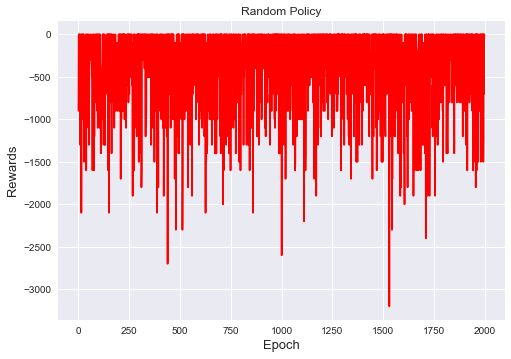

In [5]:
plt.style.use("seaborn")

env = MouseGrid()
agent = randomPolicy()
random_policy = startLearning(env, agent, epochs = 2000, agentLearning=False)

plt.plot(random_policy, color = "red")
plt.title("Random Policy")
plt.xlabel("Epoch", fontsize=13)
plt.ylabel("Rewards", fontsize=13)

Now I implement Q-Learning with different values for Alpha, the learning rate.

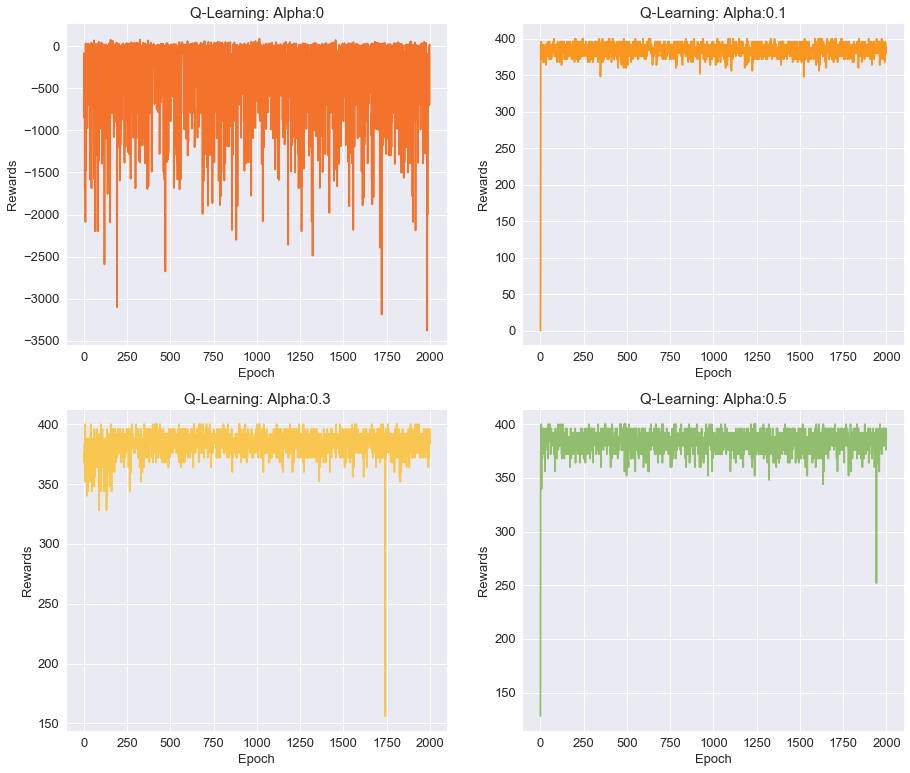

In [6]:
environment = MouseGrid()

# First Q-Leanring run
agentQ1 = QLearning(environment,learningRate = 0 )
ql_1 = startLearning(environment, agentQ1, epochs = 2000, agentLearning=True) 

# Second Q-Leanring run
agentQ2 = QLearning(environment, learningRate = 0.1)
ql_2 = startLearning(environment, agentQ2, epochs = 2000, agentLearning=True) 

# Third Q-Leanring run
agentQ3 = QLearning(environment, learningRate = 0.3)
ql_3 = startLearning(environment, agentQ3, epochs = 2000, agentLearning=True) 

# Fourth Q-Leanring run
agentQ4 = QLearning(environment, learningRate = 0.5)
ql_4 = startLearning(environment, agentQ4, epochs = 2000, agentLearning=True) 


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 13))

ax1.plot(ql_1, color="#f3722c")
ax1.set_title("Q-Learning: Alpha:0", fontsize=15)
ax1.set_xlabel("Epoch", fontsize=13)
ax1.set_ylabel("Rewards", fontsize=13)
ax1.tick_params(labelsize=13)

ax2.plot(ql_2, color = "#f8961e")
ax2.set_title("Q-Learning: Alpha:0.1", fontsize=15)
ax2.set_xlabel("Epoch", fontsize=13)
ax2.set_ylabel("Rewards", fontsize=13)
ax2.tick_params(labelsize=13)

ax3.plot(ql_3, color = "#f9c74f")
ax3.set_title("Q-Learning: Alpha:0.3", fontsize=15)
ax3.set_xlabel("Epoch", fontsize=13)
ax3.set_ylabel("Rewards", fontsize=13)
ax3.tick_params(labelsize=13)

ax4.plot(ql_4, color = "#90be6d")
ax4.set_title("Q-Learning: Alpha:0.5", fontsize=15)
ax4.set_xlabel("Epoch", fontsize=13)
ax4.set_ylabel("Rewards", fontsize=13)
ax4.tick_params(labelsize=13)

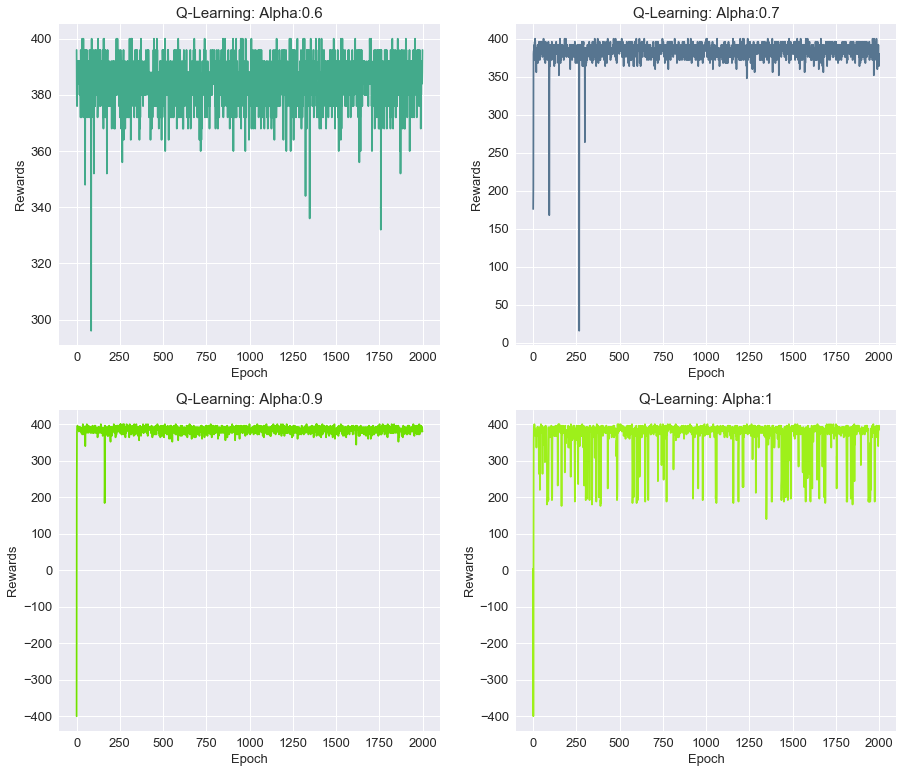

In [7]:
# Fifth Q-Leanring run
agentQ5 = QLearning(environment, learningRate = 0.6)
ql_5 = startLearning(environment, agentQ5, epochs = 2000, agentLearning=True) 

# Sixth Q-Leanring run
agentQ6 = QLearning(environment, learningRate = 0.7)
ql_6 = startLearning(environment, agentQ6, epochs = 2000, agentLearning=True) 

# Seventh Q-Leanring run
agentQ7 = QLearning(environment, learningRate = 0.9)
ql_7 = startLearning(environment, agentQ7, epochs = 2000, agentLearning=True) 

# Eighth Q-Leanring run
agentQ8 = QLearning(environment, learningRate = 1)
ql_8 = startLearning(environment, agentQ8, epochs = 2000, agentLearning=True) 


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 13))

ax1.plot(ql_5, color = "#43aa8b")
ax1.set_title("Q-Learning: Alpha:0.6", fontsize=15)
ax1.set_xlabel("Epoch", fontsize=13)
ax1.set_ylabel("Rewards", fontsize=13)
ax1.tick_params(labelsize=13)

ax2.plot(ql_6, color = "#577590")
ax2.set_title("Q-Learning: Alpha:0.7", fontsize=15)
ax2.set_xlabel("Epoch", fontsize=13)
ax2.set_ylabel("Rewards", fontsize=13)
ax2.tick_params(labelsize=13)

ax3.plot(ql_7, color = "#70e000")
ax3.set_title("Q-Learning: Alpha:0.9", fontsize=15)
ax3.set_xlabel("Epoch", fontsize=13)
ax3.set_ylabel("Rewards", fontsize=13)
ax3.tick_params(labelsize=13)

ax4.plot(ql_8, color = "#9ef01a")
ax4.set_title("Q-Learning: Alpha:1", fontsize=15)
ax4.set_xlabel("Epoch", fontsize=13)
ax4.set_ylabel("Rewards", fontsize=13)
ax4.tick_params(labelsize=13)

Now I implement Q-Learning with different values for Gamma, the discount factor.

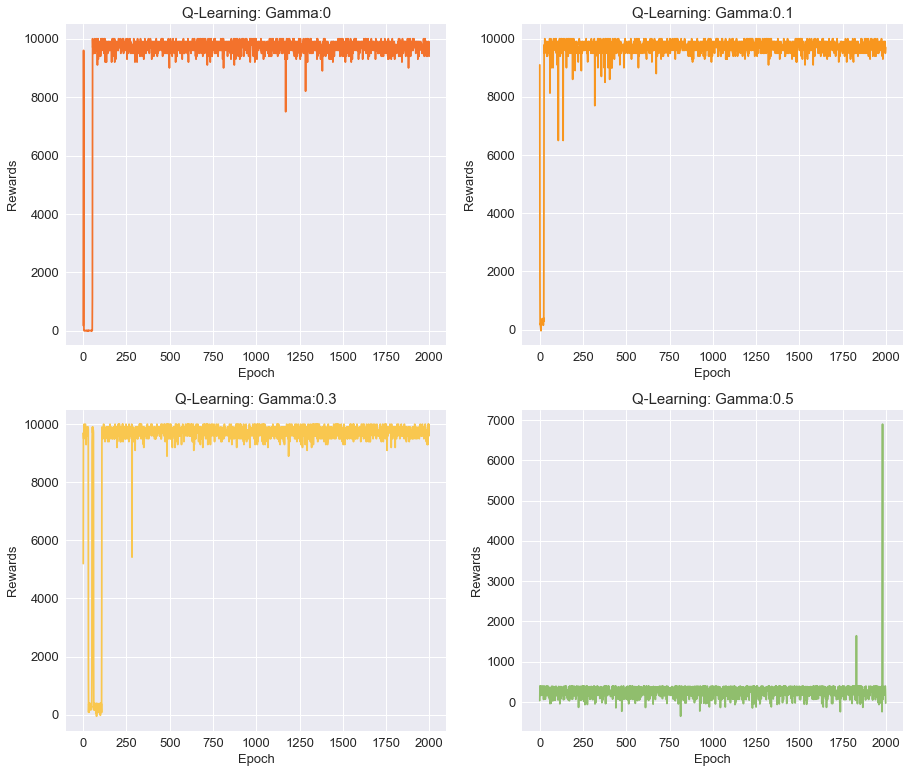

In [8]:
environment = MouseGrid()
agentQ1 = QLearning(environment)

# First Q-Leanring run
ql_1 = startLearning(environment, agentQ1, epochs = 2000, agentLearning=True) 
agentQ1 = QLearning(environment, discountFactor = 0)

# Second Q-Leanring run
agentQ2 = QLearning(environment, discountFactor = 0.1)
ql_2 = startLearning(environment, agentQ2, epochs = 2000, agentLearning=True) 

# Third Q-Leanring run
agentQ3 = QLearning(environment, discountFactor= 0.3)
ql_3 = startLearning(environment, agentQ3, epochs = 2000, agentLearning=True) 

# Fourth Q-Leanring run
agentQ4 = QLearning(environment, discountFactor= 0.5)
ql_4 = startLearning(environment, agentQ4, epochs = 2000, agentLearning=True) 


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 13))

ax1.plot(ql_1, color="#f3722c")
ax1.set_title("Q-Learning: Gamma:0", fontsize=15)
ax1.set_xlabel("Epoch", fontsize=13)
ax1.set_ylabel("Rewards", fontsize=13)
ax1.tick_params(labelsize=13)

ax2.plot(ql_2, color = "#f8961e")
ax2.set_title("Q-Learning: Gamma:0.1", fontsize=15)
ax2.set_xlabel("Epoch", fontsize=13)
ax2.set_ylabel("Rewards", fontsize=13)
ax2.tick_params(labelsize=13)

ax3.plot(ql_3, color = "#f9c74f")
ax3.set_title("Q-Learning: Gamma:0.3", fontsize=15)
ax3.set_xlabel("Epoch", fontsize=13)
ax3.set_ylabel("Rewards", fontsize=13)
ax3.tick_params(labelsize=13)

ax4.plot(ql_4, color = "#90be6d")
ax4.set_title("Q-Learning: Gamma:0.5", fontsize=15)
ax4.set_xlabel("Epoch", fontsize=13)
ax4.set_ylabel("Rewards", fontsize=13)
ax4.tick_params(labelsize=13)

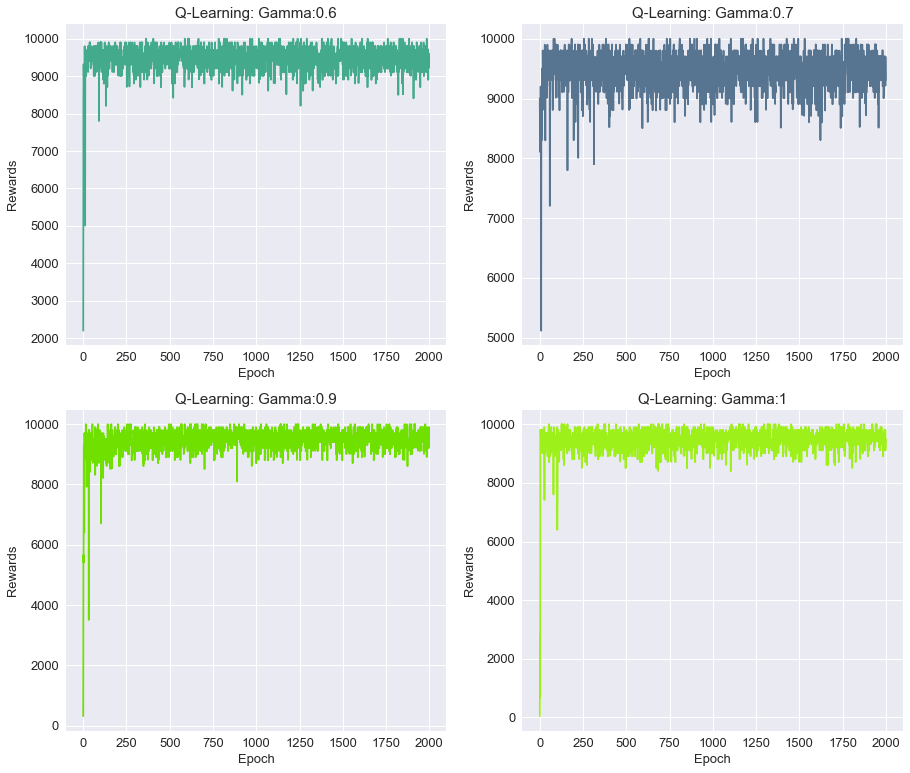

In [9]:
environment = MouseGrid()

# Fifth Q-Leanring run
agentQ5 = QLearning(environment, discountFactor = 0.6)
ql_5 = startLearning(environment, agentQ5, epochs = 2000, agentLearning=True) 

# Sixth Q-Leanring run
agentQ6 = QLearning(environment, discountFactor = 0.7)
ql_6 = startLearning(environment, agentQ6, epochs = 2000, agentLearning=True) 

# Seventh Q-Leanring run
agentQ7 = QLearning(environment, discountFactor= 0.9)
ql_7 = startLearning(environment, agentQ7, epochs = 2000, agentLearning=True) 

# Eighth Q-Leanring run
agentQ8 = QLearning(environment, discountFactor= 1)
ql_8 = startLearning(environment, agentQ8, epochs = 2000, agentLearning=True) 


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 13))

ax1.plot(ql_5, color="#43aa8b")
ax1.set_title("Q-Learning: Gamma:0.6", fontsize=15)
ax1.set_xlabel("Epoch", fontsize=13)
ax1.set_ylabel("Rewards", fontsize=13)
ax1.tick_params(labelsize=13)

ax2.plot(ql_6, color = "#577590")
ax2.set_title("Q-Learning: Gamma:0.7", fontsize=15)
ax2.set_xlabel("Epoch", fontsize=13)
ax2.set_ylabel("Rewards", fontsize=13)
ax2.tick_params(labelsize=13)

ax3.plot(ql_7, color = "#70e000")
ax3.set_title("Q-Learning: Gamma:0.9", fontsize=15)
ax3.set_xlabel("Epoch", fontsize=13)
ax3.set_ylabel("Rewards", fontsize=13)
ax3.tick_params(labelsize=13)

ax4.plot(ql_8, color = "#9ef01a")
ax4.set_title("Q-Learning: Gamma:1", fontsize=15)
ax4.set_xlabel("Epoch", fontsize=13)
ax4.set_ylabel("Rewards", fontsize=13)
ax4.tick_params(labelsize=13)

Now I implement Q-Learning with different epsilon values.

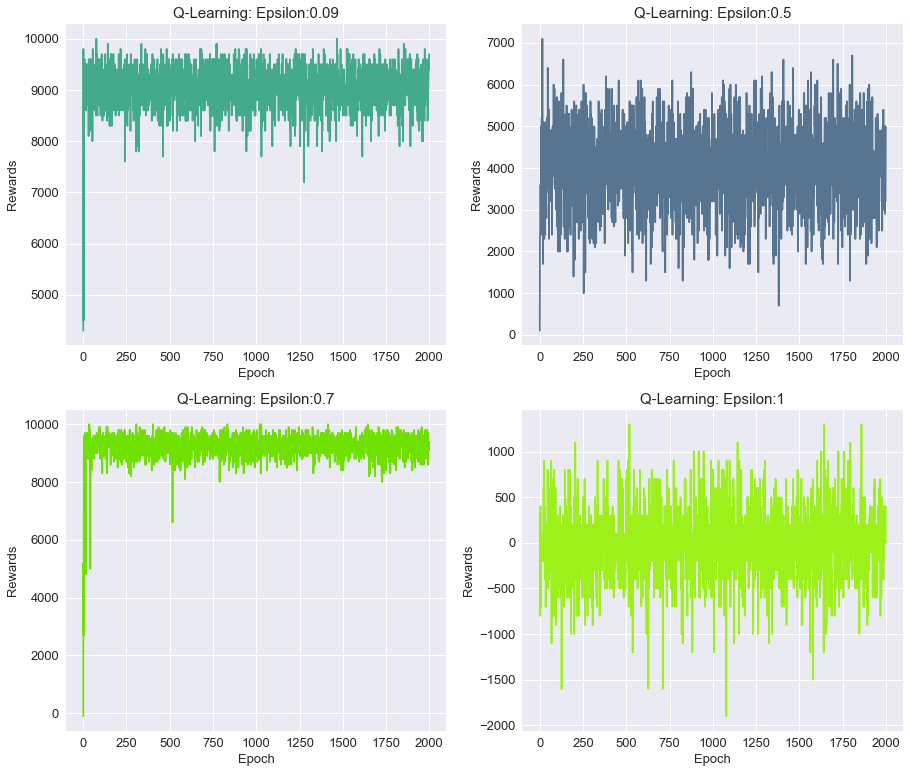

In [10]:
environment = MouseGrid()

# Fifth Q-Leanring run
agentQ5 = QLearning(environment, epsilon = 0.09)
ql_5 = startLearning(environment, agentQ5, epochs = 2000, agentLearning=True)
# Second Q-Leanring run
agentQ6 = QLearning(environment, epsilon= 0.5)
ql_6 = startLearning(environment, agentQ6, epochs = 2000, agentLearning=True) 

# Third Q-Leanring run
agentQ7 = QLearning(environment, epsilon=0.07)
ql_7 = startLearning(environment, agentQ7, epochs = 2000, agentLearning=True) 

# Fourth Q-Leanring run
agentQ8 = QLearning(environment, epsilon=1)
ql_8 = startLearning(environment, agentQ8, epochs = 2000, agentLearning=True) 


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 13))

ax1.plot(ql_5, color="#43aa8b")
ax1.set_title("Q-Learning: Epsilon:0.09", fontsize=15)
ax1.set_xlabel("Epoch", fontsize=13)
ax1.set_ylabel("Rewards", fontsize=13)
ax1.tick_params(labelsize=13)

ax2.plot(ql_6, color = "#577590")
ax2.set_title("Q-Learning: Epsilon:0.5", fontsize=15)
ax2.set_xlabel("Epoch", fontsize=13)
ax2.set_ylabel("Rewards", fontsize=13)
ax2.tick_params(labelsize=13)

ax3.plot(ql_7, color = "#70e000")
ax3.set_title("Q-Learning: Epsilon:0.7", fontsize=15)
ax3.set_xlabel("Epoch", fontsize=13)
ax3.set_ylabel("Rewards", fontsize=13)
ax3.tick_params(labelsize=13)

ax4.plot(ql_8, color = "#9ef01a")
ax4.set_title("Q-Learning: Epsilon:1", fontsize=15)
ax4.set_xlabel("Epoch", fontsize=13)
ax4.set_ylabel("Rewards", fontsize=13)
ax4.tick_params(labelsize=13)